In [1]:
# IMPORTS from tvm, different required packages and the profiling infrastructure

from numpy.core.numeric import full
import tvm
from tvm.contrib import utils, graph_executor as runtime
from tvm.relay.op.nn.nn import dense, dilate, conv2d
#####
import numpy as np
import pynvml as nv
from func_timeout import func_timeout
import time
import psutil

#####
from components import description_vector as dv
from components import serializer
from components import profiling

In [2]:
# set default figure size
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)

In [3]:
# helpful to suppress output of debug runtime run function
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [4]:
# defining important variables for the profiling system

target = "cuda"
target_class = "cuda"

device = "980ti"
dev_idx = 1
dev = tvm.device(str("cuda"), dev_idx)
time_min_res = 0.2


state_path = "./states"
state_file = "state"

layer_name = "conv2d"

metrics = profiling.get_metrics(target, device, backend="nvml", dev_idx=dev_idx)
print(metrics)

['nvml:::NVIDIA_GeForce_GTX_980_Ti:device_1:power']


In [5]:
nv.nvmlInit()
handle = nv.nvmlDeviceGetHandleByIndex(0)

#metrics.append("nvml:::NVIDIA_GeForce_GTX_980_Ti:device_1:pstate") #unable to read using TVM PAPI Profiler due to limitation to integer data
metrics.append("nvml:::NVIDIA_GeForce_GTX_980_Ti:device_"+str(dev_idx)+":gpu_utilization")
metrics.append("nvml:::NVIDIA_GeForce_GTX_980_Ti:device_"+str(dev_idx)+":memory_utilization")
metrics.append("nvml:::NVIDIA_GeForce_GTX_980_Ti:device_"+str(dev_idx)+":graphics_clock")
metrics.append("nvml:::NVIDIA_GeForce_GTX_980_Ti:device_"+str(dev_idx)+":sm_clock")
metrics.append("nvml:::NVIDIA_GeForce_GTX_980_Ti:device_"+str(dev_idx)+":memory_clock")
metrics.append("nvml:::NVIDIA_GeForce_GTX_980_Ti:device_"+str(dev_idx)+":allocated_memory")

In [6]:
config = {}
config["n"] = 1
config["h"] = 225
config["w"] = 225
config["c"] = 3
config["pad"] = 0
config["dilation"] = 1
config["kernel"] = 3
config["strides"] = 1
config["grps"] = 1
config["channels"] = 32

In [7]:
measurements = {}
a_range = [3]
b_range = range(1, 30, 1)
for n in a_range:
    for i in b_range:
        state = i
        config["c"] = n
        config["kernel"] = i
        
        #print(config)
        # prepare input tensors
        repeat = 1024
        required = int(config["n"]) * int(config["c"]) * int(config["h"]) * int(config["w"])
        '''
        inp_shape = (
            int(config["h"]),
            int(config["w"]),
            int(config["c"]),
            int(config["n"])
        )
        '''
        inp_shape = (
            int(config["n"]),
            int(config["c"]),
            int(config["h"]),
            int(config["w"]),
        )
        rand_data = np.random.rand(int(np.ceil(required/repeat)))
        inp_data = np.repeat(rand_data, repeat)[:required].reshape(inp_shape).astype("float32")
        #inp_data = np.random.rand(np.prod(inp_shape)).reshape(inp_shape).astype("float32")

        '''
        weight_shape = (
            int(config["kernel"]),
            int(config["kernel"]),
            int(config["c"] / config["grps"]),
            int(config["channels"]),
        )
        '''
        weight_shape = (
            int(config["channels"]),
            int(config["c"] / config["grps"]),
            int(config["kernel"]),
            int(config["kernel"])
        )
        required = int(config["channels"]) * int(config["c"] / config["grps"]) * int(config["kernel"]) * int(config["kernel"])
        rand_data = np.random.rand(int(np.ceil(required/repeat)))
        weight_data = np.repeat(rand_data, repeat)[:required].reshape(weight_shape).astype("float32")
        #weight_data = np.random.rand(np.prod(weight_shape)).reshape(weight_shape).astype("float32")
        x = tvm.relay.var("data", tvm.relay.TensorType(inp_shape), dtype="float32")
        y = tvm.relay.Constant(tvm.nd.array(weight_data))

        # compile with TVM
        expr = conv2d(
            data = x,
            weight= y,
            strides=int(config["strides"]),
            padding=int(config["pad"]),
            dilation=int(config["dilation"]),
            groups=int(config["grps"]),
            channels=int(config["channels"]),
            kernel_size=int(config["kernel"]),
            data_layout="NCHW",
            kernel_layout="OIHW",
            #data_layout="NHWC",
            #kernel_layout="HWIO",
        )
        
        mod = tvm.ir.IRModule.from_expr(expr)
        params = {}
        with tvm.transform.PassContext(opt_level=3):
            compiled_graph_lib = tvm.relay.build_module.build(mod, target_class, params=params)

        # measuring the execution time
        from tvm.contrib.debugger import debug_executor as graph_runtime

        ## building runtime
        debug_g_mod = graph_runtime.GraphModuleDebug(
            compiled_graph_lib["debug_create"]("default", dev),
            [dev],
            compiled_graph_lib.get_graph_json(),
            "."
        )
        
        #### NEW FUNCTION TO GET THE LAYER RUNTIME
        t_start  = time.monotonic()
        times = debug_g_mod.run_individual(10, 3, 1000)
        t_end = time.monotonic()
        
        try:
            for idx, node in enumerate(debug_g_mod.debug_datum._nodes_list):
                if layer_name in node["op"]:
                    layer_time = float(times[idx])*1000
                    actual_layer_name = node["op"]

            #print(layer_time, "ms")

            runs = int(max(1, np.ceil(time_min_res / (layer_time/1000))))

            # determine the noise
            iterations = 20
            powers = []
            gpu_utils = []
            mem_utils = []
            gpu_clocks = []
            sm_clocks = []
            mem_clocks = []
            alloc_memory = []
            profile_times = []

            # burn in 
            t_burn_in = 5
            t_start = time.monotonic()
            t_end = t_start + t_burn_in
            while time.monotonic() < t_end:
                # run debug runtime without profiling as burn in
                with suppress_stdout():
                    test_data = debug_g_mod.profile(collectors=[], data=tvm.nd.array(inp_data.astype("float32")), runs=runs)

            p_start = time.monotonic()
            for r in range(0, iterations):        
                # reload the Metric Collector due to issues with the PAPI backend
                data_collector = tvm.runtime.profiling.PAPIMetricCollector({dev: metrics}, component="nvml")    

                # run debug runtime with time measurements only
                #with suppress_stdout():
                test_data = debug_g_mod.profile(collectors=[data_collector], data=tvm.nd.array(inp_data.astype("float32")), runs=runs)
                pstate = nv.nvmlDeviceGetPowerState(handle)
                #print("\r",(r+1),"PState:", pstate, end="")

                # extract measurement of current run
                powers.append(test_data.calls[0][metrics[0]].value)
                gpu_utils.append(test_data.calls[0][metrics[1]].value)
                mem_utils.append(test_data.calls[0][metrics[2]].value)
                gpu_clocks.append(test_data.calls[0][metrics[3]].value)
                sm_clocks.append(test_data.calls[0][metrics[4]].value)
                mem_clocks.append(test_data.calls[0][metrics[5]].value)
                alloc_memory.append(test_data.calls[0][metrics[6]].value)
                profile_times.append(test_data.calls[0]["Duration (us)"].microseconds/1000000/runs) # in seconds
                #time.sleep(1)

            p_delta = time.monotonic() - p_start
            avg_power = np.mean(powers)/1000
            max_power = np.max(powers)/1000
            min_power = np.min(powers)/1000
            std_power = np.std(powers)/1000
            #calculate Z-Score
            z_scores = ((np.array(powers)/1000) - avg_power)/std_power
            cleaned_powers = []
            threshold = 0.25
            while len(cleaned_powers) < 3:
                cleaned_powers = []
                threshold += 0.05
                for idx, score in enumerate(z_scores):
                    if abs(score) < threshold:
                        cleaned_powers.append(powers[idx]/1000)

            layer_power = np.median(cleaned_powers)
            layer_memory = np.median(alloc_memory)/(1024**3)

            #print()
            measurements[state] = (layer_time, layer_power, layer_memory)
            print(state, (layer_time, layer_power, layer_memory))
            #print()
        except:
            print("failed measurement")
            #measurements[state] = (-1, -1, -1)

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.
[09:57:30] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[09:57:30] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 45.96 us/iter
[09:57:31] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[09:57:31] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 46.2885 us/iter
[09:57:33] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[09:57:33] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 46.2919 us/iter


1 (0.046291900000000004, 177.265, 0.10357666015625)


[09:57:45] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[09:57:45] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 40.3228 us/iter
[09:57:46] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[09:57:46] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 40.2983 us/iter
[09:57:47] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[09:57:47] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 40.2934 us/iter


2 (0.0402934, 185.077, 0.10443115234375)


[09:57:59] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[09:57:59] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 599.992 us/iter
[09:58:01] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[09:58:01] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 599.094 us/iter
[09:58:02] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[09:58:02] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 599.143 us/iter


3 (0.599143, 181.259, 0.10345458984375)


[09:58:14] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[09:58:14] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 157.121 us/iter
[09:58:16] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[09:58:16] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 157.071 us/iter
[09:58:17] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[09:58:17] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 157.107 us/iter


4 (0.157107, 198.5815, 0.10443115234375)


[09:58:30] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[09:58:30] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 304.95 us/iter
[09:58:31] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[09:58:31] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 305.006 us/iter
[09:58:32] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[09:58:32] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 304.958 us/iter


5 (0.30495799999999995, 194.036, 0.10333251953125)


[09:58:45] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[09:58:45] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 124.792 us/iter
[09:58:46] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[09:58:46] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 124.81 us/iter
[09:58:48] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[09:58:48] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 124.892 us/iter


6 (0.124892, 247.178, 0.10430908203125)


[09:59:00] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[09:59:00] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1068.62 us/iter
[09:59:01] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[09:59:01] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1068.65 us/iter
[09:59:03] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[09:59:03] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1068.49 us/iter


7 (1.0684900000000002, 178.356, 0.10321044921875)


[09:59:15] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[09:59:15] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1444.46 us/iter
[09:59:17] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[09:59:17] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1444.15 us/iter
[09:59:18] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[09:59:18] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1444.31 us/iter


8 (1.44431, 164.648, 0.10418701171875)


[09:59:31] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[09:59:31] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1915.54 us/iter
[09:59:32] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[09:59:32] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1915.52 us/iter
[09:59:33] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[09:59:33] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1918.07 us/iter


9 (1.91807, 241.997, 0.10308837890625)


[09:59:46] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[09:59:46] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 281.443 us/iter
[09:59:47] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[09:59:47] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 281.4 us/iter
[09:59:49] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[09:59:49] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 281.37 us/iter


10 (0.28137, 238.6515, 0.10406494140625)


[10:00:01] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:00:01] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 2435 us/iter
[10:00:03] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:00:03] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 2431.91 us/iter
[10:00:04] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:00:04] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 2431.56 us/iter


11 (2.43156, 209.975, 0.10308837890625)


[10:00:16] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:00:16] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 3365.57 us/iter
[10:00:18] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:00:18] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 3364.59 us/iter
[10:00:19] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:00:19] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 3364.89 us/iter


12 (3.36489, 240.476, 0.10394287109375)


[10:00:32] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:00:32] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 5837.54 us/iter
[10:00:33] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:00:33] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 5839.96 us/iter
[10:00:35] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:00:35] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 5849.61 us/iter


13 (5.84961, 188.94, 0.10296630859375)


[10:00:48] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:00:48] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1395.99 us/iter
[10:00:49] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:00:49] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1395.77 us/iter
[10:00:51] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:00:51] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1396.01 us/iter


14 (1.39601, 214.759, 0.10382080078125)


[10:01:03] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:01:03] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 73528.4 us/iter
[10:01:04] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:01:04] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 73516.1 us/iter
[10:01:05] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:01:05] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 73515.3 us/iter


15 (73.51530000000001, 116.739, 0.10284423828125)


[10:01:23] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:01:23] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1093.8 us/iter
[10:01:24] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:01:24] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1104.82 us/iter
[10:01:26] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:01:26] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1107.49 us/iter


16 (1.10749, 235.3585, 0.10382080078125)


[10:01:38] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:01:38] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 2826.46 us/iter
[10:01:40] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:01:40] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 2826.88 us/iter
[10:01:41] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:01:41] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 2827.05 us/iter


17 (2.82705, 220.909, 0.10272216796875)


[10:01:53] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:01:53] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 893.425 us/iter
[10:01:55] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:01:55] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 893.629 us/iter
[10:01:56] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:01:56] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 892.408 us/iter


18 (0.892408, 246.471, 0.10369873046875)


[10:02:09] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:02:09] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 3420.7 us/iter
[10:02:10] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:02:10] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 3420.39 us/iter
[10:02:12] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:02:12] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 3419.65 us/iter


19 (3.4196500000000003, 210.302, 0.10260009765625)


[10:02:24] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:02:24] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 8327.13 us/iter
[10:02:26] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:02:26] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 8317.15 us/iter
[10:02:27] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:02:27] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 8315.85 us/iter


20 (8.31585, 168.38549999999998, 0.10357666015625)


[10:02:40] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:02:40] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 14869.1 us/iter
[10:02:42] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:02:42] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 14865 us/iter
[10:02:43] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:02:43] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 14868.2 us/iter


21 (14.8682, 243.5815, 0.10357666015625)


[10:02:57] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:02:57] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1515.05 us/iter
[10:02:58] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:02:58] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1514.16 us/iter
[10:03:00] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:03:00] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1515.14 us/iter


22 (1.5151400000000002, 247.1945, 0.10247802734375)


[10:03:12] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:03:12] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 7484.81 us/iter
[10:03:14] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:03:14] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 7487.81 us/iter
[10:03:15] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:03:15] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 7483.69 us/iter


23 (7.48369, 217.303, 0.10247802734375)


[10:03:28] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:03:28] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 12410.3 us/iter
[10:03:29] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:03:29] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 12406.3 us/iter
[10:03:31] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:03:31] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 12402.3 us/iter


24 (12.4023, 241.033, 0.10333251953125)


[10:03:44] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:03:44] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 22000.7 us/iter
[10:03:46] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:03:46] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 21974.1 us/iter
[10:03:47] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:03:47] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 21902.5 us/iter


25 (21.9025, 189.496, 0.10333251953125)


[10:04:02] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:04:02] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1778.69 us/iter
[10:04:03] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:04:03] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1778.48 us/iter
[10:04:05] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:04:05] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 1778.09 us/iter


26 (1.77809, 237.538, 0.10333251953125)


[10:04:18] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:04:18] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 198593 us/iter
[10:04:20] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:04:20] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 198576 us/iter
[10:04:22] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:04:22] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 198497 us/iter


27 (198.497, 117.876, 0.10321044921875)


[10:04:51] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:04:51] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 3218.33 us/iter
[10:04:53] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:04:53] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 3218.27 us/iter
[10:04:54] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:04:54] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 3217.94 us/iter


28 (3.21794, 242.841, 0.10321044921875)


[10:05:05] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 0
[10:05:05] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 105125 us/iter
[10:05:06] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 1
[10:05:06] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 105580 us/iter
[10:05:07] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:103: Iteration: 2
[10:05:07] /home/max/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:108: Op #0 tvmgen_default_fused_nn_conv2d: 104643 us/iter


29 (104.643, 184.382, 0.10308837890625)


In [8]:
print(measurements)

{1: (0.046291900000000004, 177.265, 0.10357666015625), 2: (0.0402934, 185.077, 0.10443115234375), 3: (0.599143, 181.259, 0.10345458984375), 4: (0.157107, 198.5815, 0.10443115234375), 5: (0.30495799999999995, 194.036, 0.10333251953125), 6: (0.124892, 247.178, 0.10430908203125), 7: (1.0684900000000002, 178.356, 0.10321044921875), 8: (1.44431, 164.648, 0.10418701171875), 9: (1.91807, 241.997, 0.10308837890625), 10: (0.28137, 238.6515, 0.10406494140625), 11: (2.43156, 209.975, 0.10308837890625), 12: (3.36489, 240.476, 0.10394287109375), 13: (5.84961, 188.94, 0.10296630859375), 14: (1.39601, 214.759, 0.10382080078125), 15: (73.51530000000001, 116.739, 0.10284423828125), 16: (1.10749, 235.3585, 0.10382080078125), 17: (2.82705, 220.909, 0.10272216796875), 18: (0.892408, 246.471, 0.10369873046875), 19: (3.4196500000000003, 210.302, 0.10260009765625), 20: (8.31585, 168.38549999999998, 0.10357666015625), 21: (14.8682, 243.5815, 0.10357666015625), 22: (1.5151400000000002, 247.1945, 0.102478027343

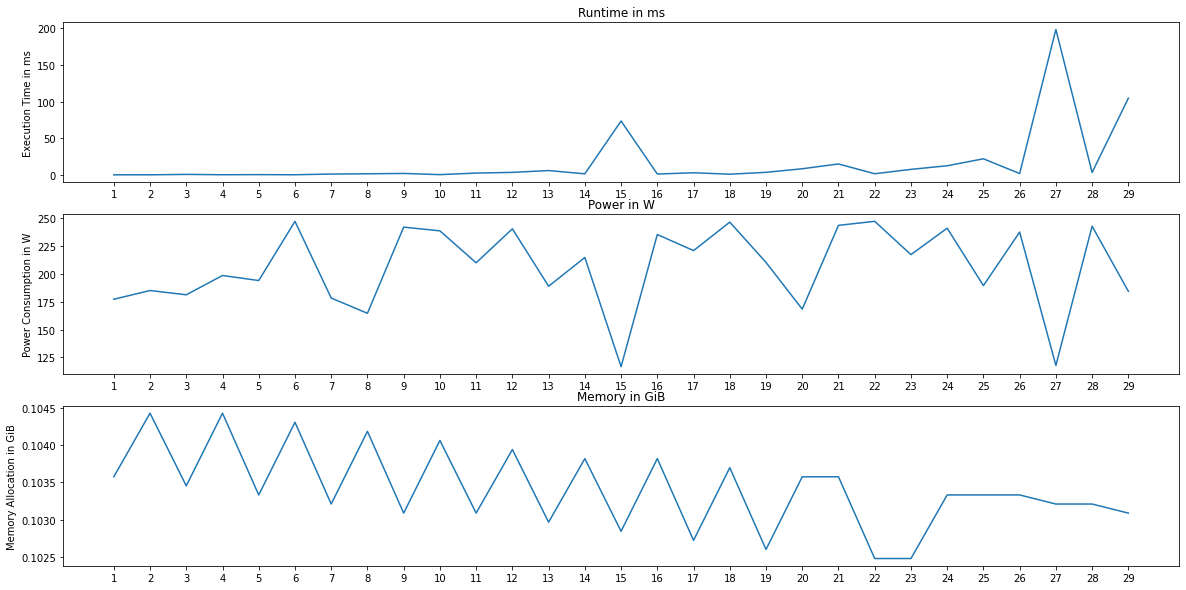

In [9]:
plt.rcParams["figure.figsize"] = (max(20, len(measurements.keys())/2.5), 10)

fig, ax = plt.subplots()
plt.subplot(3, 1, 1)
plt.plot(measurements.keys(), np.array(list(measurements.values()))[:,0])
plt.title("Runtime in ms")
#plt.xlabel("Input Height")
plt.xticks(list(measurements.keys()))
plt.ylabel("Execution Time in ms")

plt.subplot(3, 1, 2)
plt.plot(measurements.keys(), np.array(list(measurements.values()))[:,1])
plt.title("Power in W")
#plt.xlabel("Input Height")
plt.xticks(list(measurements.keys()))
plt.ylabel("Power Consumption in W")

plt.subplot(3, 1, 3)
plt.plot(measurements.keys(), np.array(list(measurements.values()))[:,2])
plt.title("Memory in GiB")
#plt.xlabel("Input Height")
plt.xticks(list(measurements.keys()))
plt.ylabel("Memory Allocation in GiB")
plt.show()

In [10]:
for key, value in measurements.items():
    #print(key)
    print(str(value[0]).replace(".",","))

0,046291900000000004
0,0402934
0,599143
0,157107
0,30495799999999995
0,124892
1,0684900000000002
1,44431
1,91807
0,28137
2,43156
3,36489
5,84961
1,39601
73,51530000000001
1,10749
2,82705
0,892408
3,4196500000000003
8,31585
14,8682
1,5151400000000002
7,48369
12,4023
21,9025
1,77809
198,497
3,21794
104,643
